# はじめての Bayes推論実習

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 問題
常に確率が一定で、前回の結果が次回に一切影響しないくじ引きがあります。ある人がくじ引きを５回引いたところ、結果は
**「当たり、はずれ、はずれ、当たり、はずれ」**
でした。
１回のくじ引きに当たる確率を $p$ とするとき、この $p$ の値を求めなさい。

### 最尤推定
尤度関数の値が最大になる Parameter $p$ の値を求める手法
#### 尤度関数
$$
f(p) = p^2(1-p)^3
$$

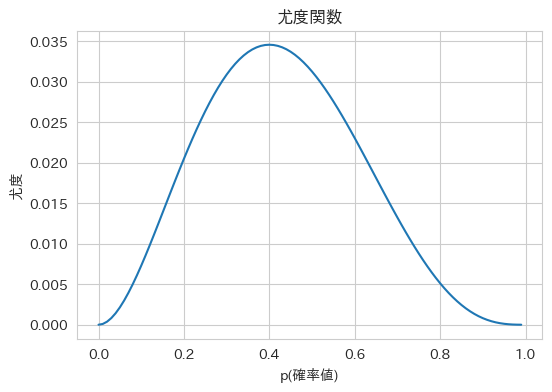

In [2]:
# 尤度関数の Graph
def likelihood(p):
    return p ** 2 * (1 - p) ** 3

# Graph 描画用 x 座標の定義
# 0.0 < x < 1.0
p = np.arange(0.0, 1.0, 0.01)

# Graph描画
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(p, likelihood(p))
plt.xlabel('p(確率値)')
plt.ylabel('尤度')
plt.title('尤度関数')
plt.show()

In [4]:
# PyTorch を install
# !pipenv install torch

Installing torch...
⠇ ✔ Installation Succeededtorch to Pipfile's ...
Pipfile.lock (2318f2) out of date, updating to (d5bf69)...
Locking [packages] dependencies...
⠙ ✔ Success!dependencies....
Locking [dev-packages] dependencies...
Updated Pipfile.lock (69ed1be00882a2bbc01d3ced8bc7b4031503dd45517f40adec7128ce39d5bf69)!
Installing dependencies from Pipfile.lock (d5bf69)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


In [5]:
# 最尤推定の繰り返し計算の実装
import torch  # Libray の import


def log_likelihood(p):  # 対数尤度関数
    return (2 * torch.log(p) + 3 * torch.log(1 - p))


num_epochs = 40  # 繰り返し回数
lr = 0.01  # 学習率

# Parameter初期値
p = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)

logs = np.zeros((0, 3))
for epoch in range(num_epochs):
    loss = -log_likelihood(p)  # 損失計算
    loss.backward()  # 勾配計算
    with torch.no_grad():
        p -= lr * p.grad  # Parameter修正
        p.grad.zero_()  # 勾配値の初期化
    log = np.array([epoch, p.item(), loss.item()]).reshape(1, -1)
    logs = np.vstack([logs, log])

- 尤度関数の代わりにその対数をとった **対数尤度関数** を用いている。
- マイナスをとった値を **損失** として繰り返し処理での微分計算対象としている。
- 計算の途中経過はすべて変数 `logs` に保存。

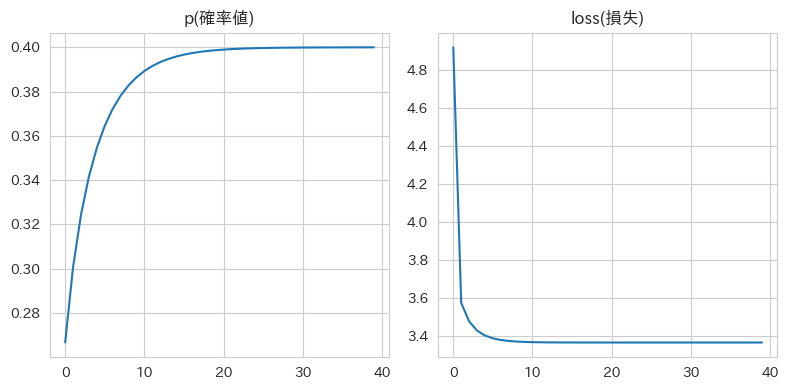

In [6]:
# 繰り返し計算の仮定を Graph表示
plt.rcParams['figure.figsize'] = (8, 4)
fig, axes = plt.subplots(1, 2)
axes[0].plot(logs[:, 0], logs[:, 1])
axes[0].set_title('p(確率値)')
axes[1].plot(logs[:, 0], logs[:, 2])
axes[1].set_title('loss(損失)')
plt.tight_layout()
plt.show()

0.40 の確率値が繰り返し計算で導出されている。

## Bayes推論（確率 Model 定義）

In [8]:
# Data準備
X = np.array([1, 0, 0, 1, 0])
print(X)

[1 0 0 1 0]


In [9]:
# 確率 Model 定義
# Context 定義
model1 = pm.Model()

with model1:
    # pm.Uniform: 一様分布
    p = pm.Uniform('p', lower=0.0, upper=1.0)

    # pm.Bernoulli: ベルヌーイ分布
    X_obs = pm.Bernoulli('X_obs', p=p, observed=X)

1. 確率変数の関係性
    一様分布の確率変数 `p` を次のベルヌーイ分布の constructor の確率値を示す引数として渡す。
2. 観測値との関係性
    観測値を表す変数 `X` をベルヌーイ分布の Constructor に対して `observed` 引数として渡す。

In [11]:
!pipenv install graphviz

Installing graphviz...
⠸ ✔ Installation Succeeded
Pipfile.lock (d5bf69) out of date, updating to (de5d96)...
Locking [packages] dependencies...
⠏ ✔ Success!dependencies.....
Locking [dev-packages] dependencies...
Updated Pipfile.lock (b18f761368e22dafb7ae5af6464629b30fe1366a93d8b83eaec3946f65de5d96)!
Installing dependencies from Pipfile.lock (de5d96)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


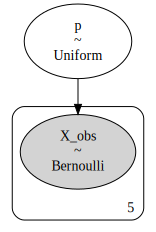

In [12]:
# 確率 Model の可視化
g = pm.model_to_graphviz(model1)
display(g)

- 丸で示される Node が確率分布を示す
- Node内の上の表記が確率変数名、下が確率分布 Class名
- 矢印により確率変数間の関係性が示される
- 繰り返し構造は枠で囲んで示す
- 枠の右下の数字は繰り返した数
- 色がついた Node は、観測値があることを示す

## Bayes推論（Sampling）
### Sampling
- PyMC において根幹的な機能
- MCMC(Markov Chain Monte Carlo) という Algorithm で観測値を満たすような、事前分布に従う乱数(Sample値)を計算していく。

#### 重要な３つの Parameters
#### chains
Sample直系列をいくつ生成するか指定する。※ Default値: 2
変更することで、より多くの Sample直系列を生成することが可能。
得られた確率分布がたまたま特定の初期 Sample値で発生したものなのか、一般的なものなのかを判断できる。
#### tune
MCMC Algorithm は、Sample直系列で見たとき、**初期状態が不安定で、徐々に結果が安定してくる** 傾向にあるので、**不安定なことの多い初期状態の Sample値を分析対象から外す** ための parameter. ※ Default値: 1000
#### draws
`tune` と逆に、分析対象として利用される Sample数を指定する。※ Default値: 1000
複雑な構成の確率 Model の場合、**予測結果をより確実なものとするため、Defaultより値を大きくする** 使い方がよく行なわれる。

### その他の Parameters
- `target_accept`: Byes推論の収束が不十分な場合に利用する Tuning-parameter
- `init`: Sampling する Parameter の初期値を決定する Algorithm に関する Parameter
- `step`: １つ前の Sampling値から次の Sampling値を計算するための Algorithm に関する Parameter

In [13]:
# Parameter値を明示的に設定して Sampling
with model1:
    idata1_1 = pm.sample(
        chains=3,  # 乱数系列の数
        tune=2000,  # 捨てる Sample数
        draws=2000,  # 利用する Sample数
        random_seed=42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [p]


Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [16]:
# Default値で Sampling
with model1:
    idata1_2 = pm.sample(chains=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Bayes推論（結果分析）
### Bayes推論の本質
本来の因果関係と逆向きに事後分布の推論をする。
1. 出発点は観測値
2. 観測値の確率分布を経由
3. 事前分布に従う確率変数の事後分布が Sample値の配列として得られる。
4. 得られた Sample値の配列に対して分析し **事後分布の性質を確認する**

### 結果分析で実施すること
1. Sampling が正常にできていることの確認
2. 可視化による確率分布の確認
3. 統計分析による確率分布の確認

### `az.plot_trace()` 関数
主に Sampling が正常にできていることの確認で利用する。

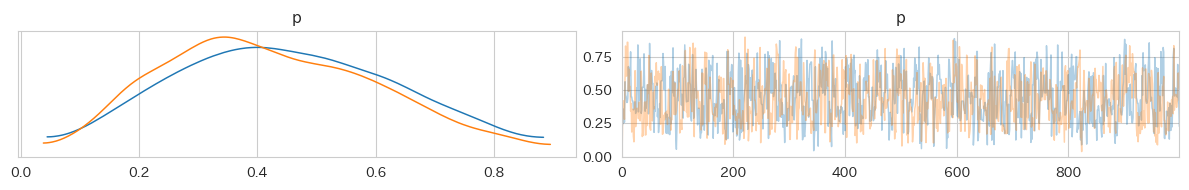

In [18]:
# plot_trace()関数の呼び出し
az.plot_trace(idata1_2, compact=False)  # compact=False: 複数の Sample値系列の色分けをする
plt.tight_layout()  # 複数の Graph がぶつからないようにする
plt.show()

２つの Graph の形がほぼ同じ = Bayes推論の Algorithm がうまく動いていることを意味する。
※複数の Graph が極端に異なる場合は、確率Model の組み方などの問題があることを意味しているので対応が必要になる。

### `plot_posterior()`関数
可視化による確率分布の確認方法として最もよく利用される。

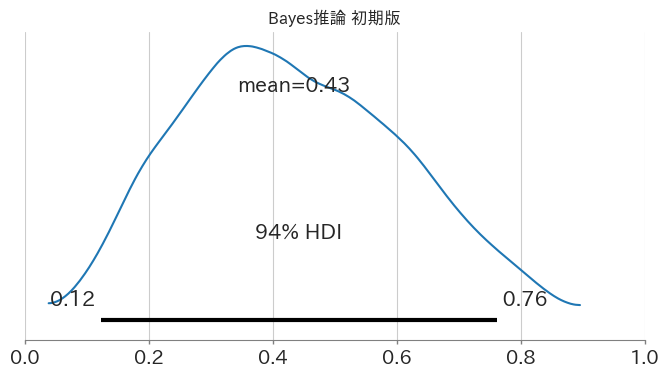

In [19]:
# plot_posterior()関数呼び出し
ax = az.plot_posterior(idata1_2)
ax.set_xlim(0, 1)
ax.set_title('Bayes推論 初期版')
plt.show()

### `summary()`関数
- Sample値の統計分析
- Bayes推論が正しくできていることの確認

で用いられる。

In [21]:
# summary()関数呼び出し
summary1_2 = az.summary(idata1_2)
display(summary1_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.434,0.177,0.123,0.761,0.006,0.004,873.0,1315.0,1.0


mcse_mean以降の項目は Bayes推論の Algorithm が問題なく機能しているか確認するための指標。
#### 目安
- mcse_mean: 0.01以下
- ess_bulk: 400以上
- r_hat: 1.01以下

>略語の語源
> mcse(Monte Carlo standard error: モンテカルロ標準エラー)
ess(effective sample size: 有効 Sample-size)